In [1]:
%config Completer.use_jedi = False
import sys, os
sys.path.append('../pyecog2')
sys.path.append('../')
from ProjectClass import Project,FileBuffer
from main import MainModel
import json
import feature_extractor 
import importlib
importlib.reload(feature_extractor)
FeatureExtractor = feature_extractor.FeatureExtractor

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import spectrotools as spec
importlib.reload(spec)
from numba import jit, njit
import timeit

from scipy import stats

In [2]:
main_model = MainModel()
project=Project(main_model=main_model)
project.load_from_json('/media/mfpleite/LaCie_1/ML_pyecog_2/AwesomeProject.pyecog')
fe = FeatureExtractor()

[]
copy from - history reset
[]
copy from - history reset
[]
copy from - history reset
[]
copy from - history reset
looking for h5_119
[]
copy from - history reset
['seizure', 'artefact', 'flatline', 'baseline']
copy from - history reset
current animal: h5_119


In [8]:
annotation0 = project.current_animal.annotations.annotations_list[1]
it = project.current_animal.eeg_init_time
index = [i  for i in range(len(it)) if (0<(annotation0.getStart()-it[i])<3600) ][0]
# index=0
fname = '.'.join(project.current_animal.eeg_files[index].split('.')[:-1]+['features'])
# fname ='/media/mfpleite/LaCie_1/ML_pyecog_2/data_from_ele/h5_119/M1566408624_2019-08-21-18-30-24_tids_[119].features'

f_vec = np.fromfile(fname,dtype='float64')

fmeta_file = '.'.join(project.current_animal.eeg_files[index].split('.')[:-1] + ['fmeta'])
fmeta_dict = json.load(open(fmeta_file))


In [9]:
f_vec = f_vec.reshape((-1,fe.settings['number_of_features']))
f_vec[np.where(np.isnan(f_vec))] = 0

In [10]:
starts = [(annotation0.getStart()-it[index])/2.5 for annotation0 in project.current_animal.annotations.annotations_list]
ends = [(annotation0.getEnd()-it[index])/2.5 for annotation0 in project.current_animal.annotations.annotations_list]

f_labels = np.zeros(len(f_vec),dtype='bool')
for i in range(len(starts)-1) :
    s = int(np.floor(starts[i+1]))
    e = int(np.ceil(ends[i+1]))
    f_labels[s:e] = 1
    
f_vec_d  = np.hstack([f_vec,np.vstack([np.zeros(f_vec.shape[1]),np.diff(f_vec,axis=0)])])
f_vec_d  = f_vec
f_vec_d = f_vec_d-np.mean(f_vec_d,axis=0)
f_vec_d = f_vec_d/np.std(f_vec_d,axis = 0)

blanks = f_vec_d#[(1-f_labels).nonzero()[0],:]
seizures = f_vec_d[(f_labels).nonzero()[0],:]

blanks_mu  = blanks.mean(axis=0)
blanks_cov = (blanks-blanks_mu).T.dot((blanks-blanks_mu))/blanks.shape[0]
seizures_mu  = seizures.mean(axis=0)
seizures_cov = (seizures-seizures_mu).T.dot((seizures-seizures_mu))/seizures.shape[0]

[Text(0, 0, 'min'),
 Text(0, -1, 'max'),
 Text(0, -2, 'mean'),
 Text(0, -3, 'log std'),
 Text(0, -4, 'kurtosis'),
 Text(0, -5, 'skewness'),
 Text(0, -6, 'log coastline (log sum of abs diff)'),
 Text(0, -7, 'log powerf(1, 4)'),
 Text(0, -8, 'log powerf(4, 8)'),
 Text(0, -9, 'log powerf(8, 12)'),
 Text(0, -10, 'log powerf(12, 30)'),
 Text(0, -11, 'log powerf(30, 50)'),
 Text(0, -12, 'log powerf(50, 70)'),
 Text(0, -13, 'log powerf(70, 120)'),
 Text(0, -14, 'fentropy')]

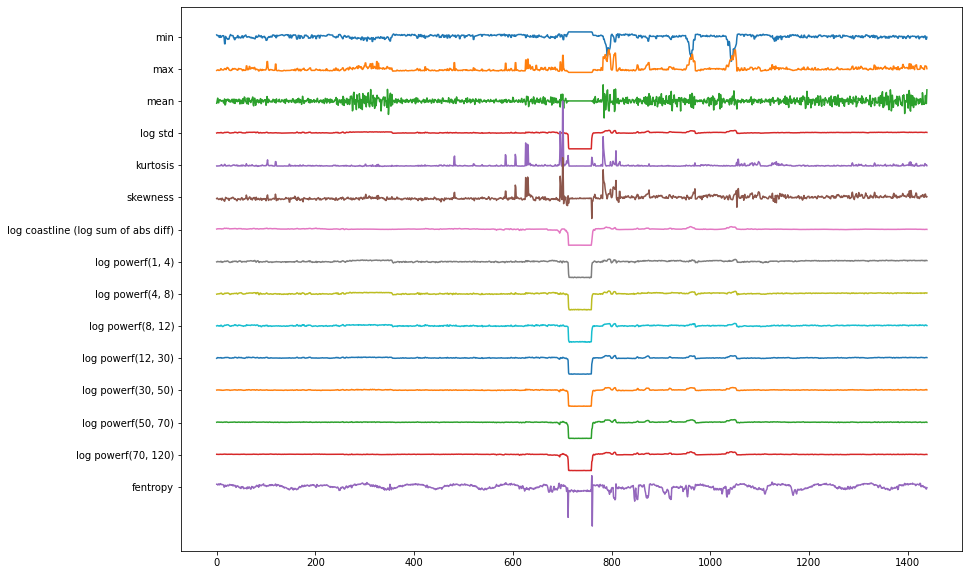

In [11]:

f = plt.figure(figsize=(14,10))
ax = f.gca()
spec.plot_spread(f_vec_d,.5);

# plt.xlim([400,1000])
# plt.vlines(starts[1:],-15,0)
# plt.vlines(ends[1:],-15,0)
ax.set_yticks(range(0,-fe.settings['number_of_features'],-1))
ax.set_yticklabels(fe.settings['feature_labels'])

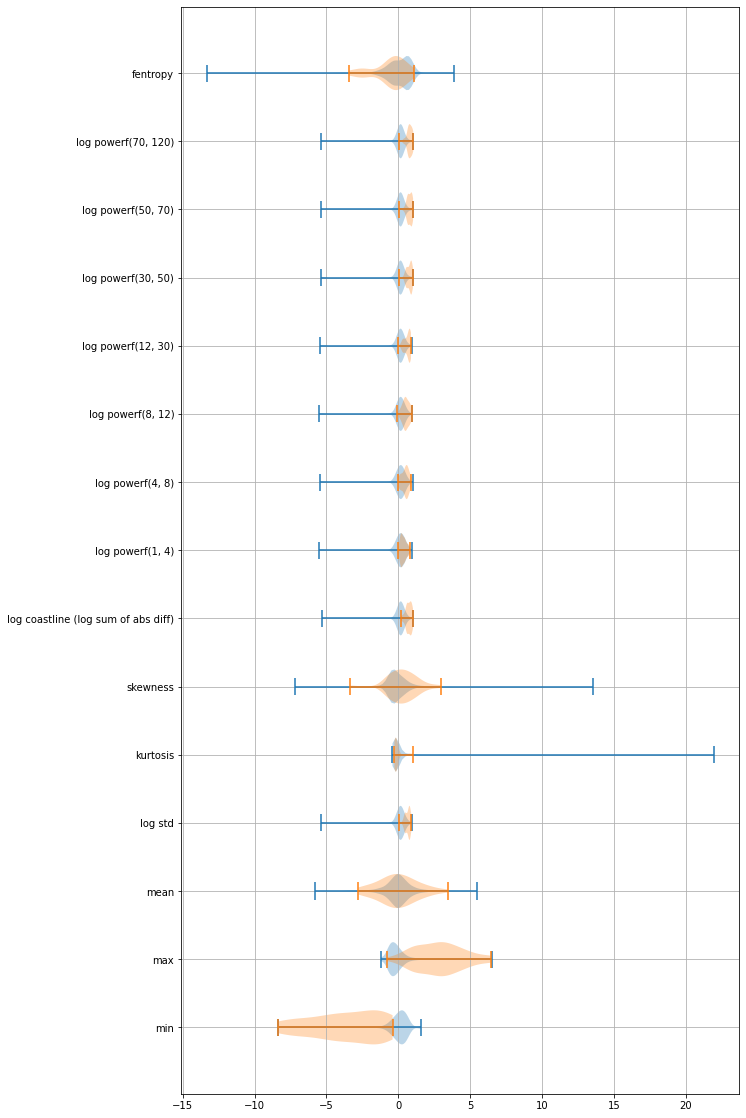

In [12]:
plt.figure(figsize=(10,20))
plt.violinplot(blanks,vert=False);
plt.violinplot(seizures,vert=False);
ax=plt.gca()
# ax.set_yticks(list(range(1,fe.settings['number_of_features']+1,1)) + 
#               list(range(fe.settings['number_of_features']+1,2*fe.settings['number_of_features']+1,1)))
# ax.set_yticklabels(fe.settings['feature_labels'] + ['d'+s+'/dt' for s in fe.settings['feature_labels']])
ax.set_yticks(list(range(1,fe.settings['number_of_features']+1,1)))
ax.set_yticklabels(fe.settings['feature_labels'])
plt.grid()

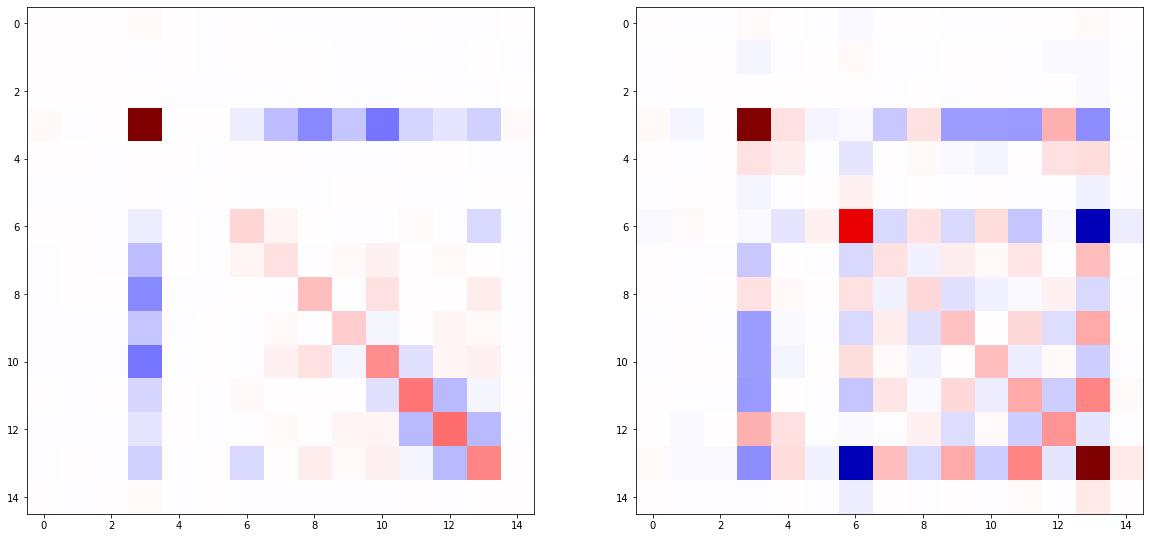

In [13]:
blanks_cov_i = np.linalg.inv(blanks_cov)
seizures_cov_i = np.linalg.inv(seizures_cov)
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(blanks_cov_i,cmap='seismic',vmin=-np.max(np.abs(blanks_cov_i)),vmax=np.max(np.abs(blanks_cov_i)))
plt.subplot(1,2,2)
plt.imshow(seizures_cov_i,cmap='seismic',vmin=-np.max(np.abs(seizures_cov_i)),vmax=np.max(np.abs(seizures_cov_i)))

In [14]:
fe.settings['feature_labels']

['min',
 'max',
 'mean',
 'log std',
 'kurtosis',
 'skewness',
 'log coastline (log sum of abs diff)',
 'log powerf(1, 4)',
 'log powerf(4, 8)',
 'log powerf(8, 12)',
 'log powerf(12, 30)',
 'log powerf(30, 50)',
 'log powerf(50, 70)',
 'log powerf(70, 120)',
 'fentropy']

In [15]:
@jit(nopython=True)
def MVGD_LL_jit(fdata,mu,inv_cov,LL,no_scale):
    k = fdata.shape[1]
    N = fdata.shape[0]
    scale = (1-no_scale)*((-k/2)*np.log(2*np.pi)+1/2*np.log(np.linalg.det(inv_cov[:,:])))
    for i in range(N):
        LL[i] = scale - 0.5*(fdata[i,:]-mu)@(inv_cov[:,:] @(fdata[i,:]-mu).T)

def MVGD_LL(fdata,mu,inv_cov,no_scale = False):
    LL = np.zeros(fdata.shape[0])
    MVGD_LL_jit(fdata,mu,inv_cov,LL, no_scale)
    return LL

@jit(nopython=True)
def LL2prob_jit(LL,prob):
    for i in range(LL.shape[0]):
        v = np.exp(LL[i,:])
        prob[i,:] = v / np.sum(v)
        
def LL2prob(LL):
    prob = np.zeros(LL.shape)
    LL2prob_jit(LL,prob)
    return prob

In [16]:
blanks_cov_i = np.linalg.inv(blanks_cov)
blanks_cov_ir = np.linalg.inv(blanks_cov+np.eye(len(blanks_cov))*blanks_cov.diagonal()/len(blanks))

seizures_cov_i = np.linalg.inv(seizures_cov)
seizures_cov_ir = np.linalg.inv(seizures_cov+np.eye(len(seizures_cov))*seizures_cov.diagonal()/len(seizures))

b_LL = MVGD_LL(f_vec_d,blanks_mu,blanks_cov_i)
s_LL = MVGD_LL(f_vec_d,seizures_mu,seizures_cov_i)
b_LLr = MVGD_LL(f_vec_d,blanks_mu,blanks_cov_ir)
s_LLr = MVGD_LL(f_vec_d,seizures_mu,seizures_cov_ir)

plt.figure(figsize=(14,7))
# plt.plot(b_LL)
plt.plot(b_LLr)
# plt.plot(s_LL)
plt.plot(s_LLr)
plt.vlines(starts[1:],-2000,0,linestyles=':')
plt.vlines(ends[1:],-2000,0,linestyles=':')

plt.xlim(400,1000)
plt.ylim(-500,400)

<ipython-input-15-da9e4bc747e3>:7: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 1d, C))
  LL[i] = scale - 0.5*(fdata[i,:]-mu)@(inv_cov[:,:] @(fdata[i,:]-mu).T)


ModuleNotFoundError: can't compile MVGD_LL_jit: import of module Test failed

In [ ]:
blanks_LL = MVGD_LL(blanks,blanks_mu,blanks_cov_i,no_scale=True)
seizures_LL = MVGD_LL(seizures,seizures_mu,seizures_cov_i,no_scale=True)

blank_bias = np.log(len(blanks)/(len(blanks)+len(seizures)))
seizure_bias = np.log(len(seizures)/(len(blanks)+len(seizures)))


b_LL = MVGD_LL(f_vec_d,blanks_mu,blanks_cov_i)+ blank_bias
s_LL = MVGD_LL(f_vec_d,seizures_mu,seizures_cov_i)+ seizure_bias
b_LLr = MVGD_LL(f_vec_d,blanks_mu,blanks_cov_ir) + blank_bias
s_LLr = MVGD_LL(f_vec_d,seizures_mu,seizures_cov_ir) + seizure_bias

LL = np.array([b_LL.T,s_LL.T]).T
p  = LL2prob(LL) 

LLr = np.array([b_LLr.T,s_LLr.T]).T
pr  = LL2prob(LLr) 

plt.figure(figsize=(14,7))
plt.plot(p[:,1]*200,'.',markersize=2)
plt.plot(pr[:,1]*200,'.',markersize=1,color = [1,0,0,1])
plt.plot(b_LL,'.',markersize=2)
plt.plot(s_LL,'.',markersize=2)
plt.vlines(starts[1:],-200,0,linestyles=':')
plt.vlines(ends[1:],-200,0,linestyles=':')
plt.xlim(400,1000)

plt.figure(figsize=(14,7))
plt.plot(pr[:,1]*200,'.',markersize=2)
plt.plot(b_LLr,'.',markersize=2)
plt.plot(s_LLr,'.',markersize=2)
plt.vlines(starts[1:],-200,0,linestyles=':')
plt.vlines(ends[1:],-200,0,linestyles=':')
plt.xlim(400,1000)

In [ ]:
plt.figure(figsize=(10,10))
dof = f_vec.shape[1]
x = np.linspace(0,20,50)
chi2 = stats.chi2.pdf(x,dof,scale=0.5)
plt.subplot(321)
plt.hist(-blanks_LL,bins = x,density = True);
plt.plot(x,chi2)

cum_chi2 = stats.chi2.cdf(x,dof,scale=0.5)
plt.subplot(322)
plt.hist(-blanks_LL,bins = x,density = True,cumulative=True);
plt.plot(x,cum_chi2)

x = np.linspace(0,20,20)
chi2 = stats.chi2.pdf(x,dof,scale=0.5)
# plt.figure()
plt.subplot(323)
plt.hist(-seizures_LL,bins=x,density=True);
plt.plot(x,chi2)

cum_chi2 = stats.chi2.cdf(x,dof,scale=0.5)
plt.subplot(324)
plt.hist(-seizures_LL,bins = x,density=True,cumulative=True);
plt.plot(x,cum_chi2)


f_rand = np.random.randn(*f_vec.shape)
LL_rand = 0.5*np.sum(f_rand**2,axis = 1)
x = np.linspace(0,20,20)
chi2 = stats.chi2.pdf(x,dof,scale=0.5)
# plt.figure()
plt.subplot(325)
plt.hist(LL_rand,bins=x,density=True);
plt.plot(x,chi2)

cum_chi2 = stats.chi2.cdf(x,dof,scale=0.5)
plt.subplot(326)
plt.hist(-seizures_LL,bins = x,density = True,cumulative=True);
plt.plot(x,cum_chi2)





In [3]:
main_model = MainModel()
project=Project(main_model=main_model)
project.load_from_json('/media/mfpleite/LaCie_1/ML_pyecog_2/AwesomeProject_IIEDs.pyecog')

[]
copy from - history reset
[]
copy from - history reset
[]
copy from - history reset
[]
copy from - history reset
looking for h5_119
[]
copy from - history reset
['seizure', 'repeated IIEDs', '(auto)seizure']
copy from - history reset
current animal: h5_119


In [4]:
import classifier
from scipy import linalg

importlib.reload(classifier)

<module 'classifier' from '../pyecog2/classifier.py'>

In [5]:
GC = classifier.GaussianClassifier(project,fe,['seizure','repeated IIEDs'])
GC2 = classifier.GaussianClassifier(project,fe,['seizure','repeated IIEDs'])
GC3 = classifier.GaussianClassifier(project,fe,['seizure','repeated IIEDs'])

In [6]:
project.current_animal.annotations.labels

['seizure', 'repeated IIEDs', '(auto)seizure']

In [7]:
GC.train(project.animal_list[:1])

Training with animal: h5_119
Training with classes: ['seizure', 'repeated IIEDs']
Transitions:19 file: 1709 of 1710 /media/mfpleite/LaCie_1/ML_pyecog_2/data_from_ele/h5_119/M1572561642_2019-10-31-22-40-42_tids_[119].featuresile: 122 of 1710 /media/mfpleite/LaCie_1/ML_pyecog_2/data_from_ele/h5_119/M1566847824_2019-08-26-20-30-24_tids_[119].featuresfile: 281 of 1710 /media/mfpleite/LaCie_1/ML_pyecog_2/data_from_ele/h5_119/M1567420224_2019-09-02-11-30-24_tids_[119].features 380 of 1710 /media/mfpleite/LaCie_1/ML_pyecog_2/data_from_ele/h5_119/M1567776624_2019-09-06-14-30-24_tids_[119].features/media/mfpleite/LaCie_1/ML_pyecog_2/data_from_ele/h5_119/M1568494159_2019-09-14-21-49-19_tids_[119].featuresof 1710 /media/mfpleite/LaCie_1/ML_pyecog_2/data_from_ele/h5_119/M1572262842_2019-10-28-11-40-42_tids_[119].features 1665 of 1710 /media/mfpleite/LaCie_1/ML_pyecog_2/data_from_ele/h5_119/M1572403242_2019-10-30-02-40-42_tids_[119].features
 [[ 0. 11. 39.]
 [11.  0.  0.]
 [39.  0.  1.]]
HMM.A:
 [[

In [8]:
GC2.train(project.animal_list[1:2])

Training with animal: h5_120
Training with classes: ['seizure', 'repeated IIEDs']
Transitions:20 file: 1691 of 1692 /media/mfpleite/LaCie_1/ML_pyecog_2/data_from_ele/h5_120/M1572561642_2019-10-31-22-40-42_tids_[120].featuresfile: 1303 of 1692 /media/mfpleite/LaCie_1/ML_pyecog_2/data_from_ele/h5_120/M1571165359_2019-10-15-19-49-19_tids_[120].features
 [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
HMM.A:
 [[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


In [9]:
GC3.train(project.animal_list[1:2])

Training with animal: h5_120
Training with classes: ['seizure', 'repeated IIEDs']
Transitions:20 file: 1691 of 1692 /media/mfpleite/LaCie_1/ML_pyecog_2/data_from_ele/h5_120/M1572561642_2019-10-31-22-40-42_tids_[120].features
 [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
HMM.A:
 [[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


In [10]:
GC2.copy_re_normalized_classifier(GC)

In [13]:
mu3,W3,iW3 = GC3.whitening_mu_W_iW()
mu2,W2,iW2 = GC2.whitening_mu_W_iW()
mu,W,iW = GC.whitening_mu_W_iW()

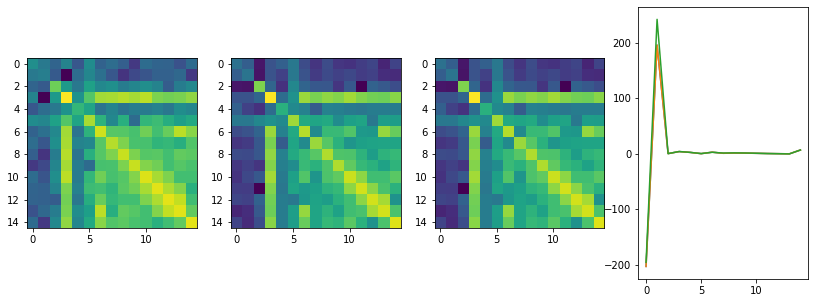

In [14]:
plt.figure(figsize=(14,5))
plt.subplot(1,4,1)
plt.imshow(np.log(np.abs(W)))
plt.subplot(1,4,2)
plt.imshow(np.log(np.abs(W2)))
plt.subplot(1,4,3)
plt.imshow(np.log(np.abs(W3)))
plt.subplot(1,4,4)
plt.plot(mu3)
plt.plot(mu2)
plt.plot(mu)

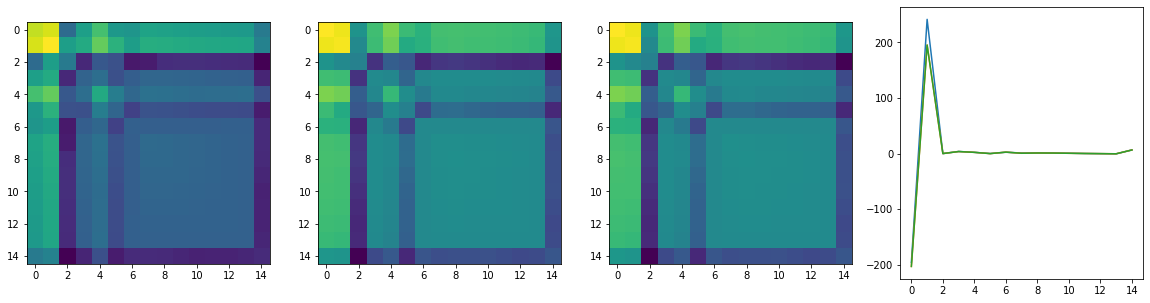

In [15]:
plt.figure(figsize=(20,5))
plt.subplot(1,4,1)
plt.imshow(np.log(np.abs(GC.blank_cov)))
plt.subplot(1,4,2)
plt.imshow(np.log(np.abs(GC2.blank_cov)))
plt.subplot(1,4,3)
plt.imshow(np.log(np.abs(GC3.blank_cov)))
plt.subplot(1,4,4)
plt.plot(GC.blank_means)
plt.plot(GC2.blank_means)
plt.plot(GC3.blank_means)

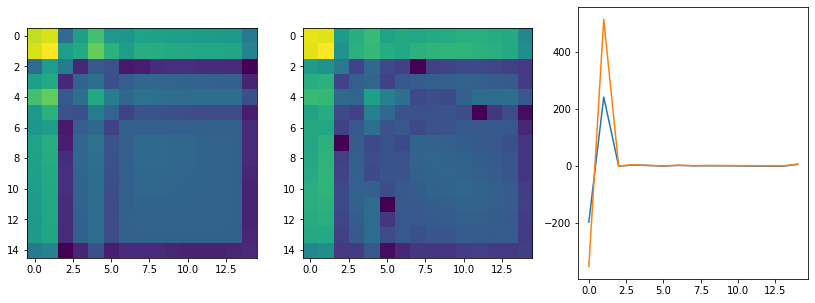

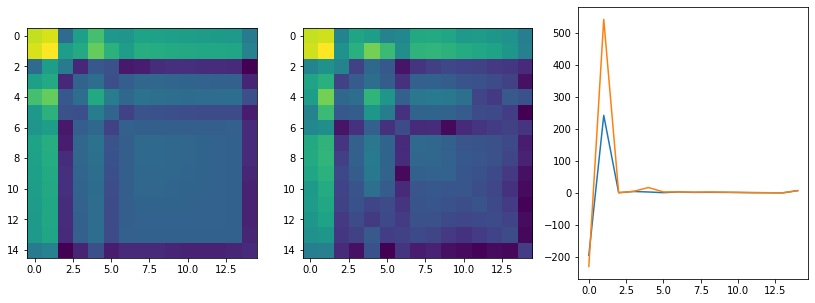

In [63]:
mu = GC.blank_means[:,np.newaxis]
cov = GC.blank_cov
npoints = GC.blank_npoints
for i in range(len(GC.labels2classify)):
    muc = GC.class_means[i][:,np.newaxis]
    covc = GC.class_cov[i]
    npointsc = GC.class_npoints[i]
    plt.figure(figsize=(14,5))
    plt.subplot(1,3,1)
    plt.imshow(np.log(np.abs(cov)))
    plt.subplot(1,3,2)
    plt.imshow(np.log(np.abs(covc)))
    plt.subplot(1,3,3)
    plt.plot(mu)
    plt.plot(muc)
    mu,cov = classifier.average_mu_and_cov(mu,cov,npoints,muc,covc,npointsc)
    npoints += npointsc

In [64]:
npoints

4922138.0

In [65]:
GC.blank_npoints

4919576

In [66]:
GC.class_means

array([[-3.51423919e+02,  5.13779225e+02,  1.80570806e-03,
         4.69156231e+00,  2.00169265e+00,  6.85473763e-01,
         3.24363660e+00,  1.42822727e+00,  2.00751396e+00,
         1.79039369e+00,  1.51050439e+00,  1.32233453e+00,
         1.04094879e+00,  5.89191443e-01,  6.26568352e+00],
       [-2.30474727e+02,  5.41701138e+02,  7.51830549e-03,
         4.24010831e+00,  1.61132161e+01,  2.37871420e+00,
         2.43018066e+00,  1.71032252e+00,  2.12867280e+00,
         1.64366436e+00,  9.81190247e-01,  3.10202299e-01,
        -3.23120963e-02, -3.94742712e-01,  6.51770913e+00]])

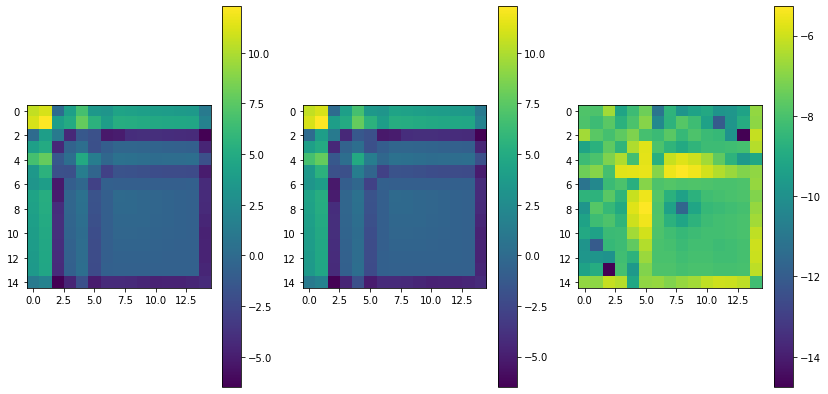

In [70]:
plt.figure(figsize=(14,7))
plt.subplot(1,3,1)
plt.imshow(np.log(np.abs(cov)))
plt.colorbar()
plt.subplot(1,3,2)
plt.imshow(np.log(np.abs(GC.blank_cov)))
plt.colorbar()
plt.subplot(1,3,3)
plt.imshow(np.log(np.abs(GC.blank_cov-cov))-np.log(np.abs(GC.blank_cov)))
# plt.imshow(np.log(np.abs(A)))
plt.colorbar()

In [23]:
A = linalg.sqrtm(classifier.reg_invcov(GC.blank_cov,GC.blank_npoints))

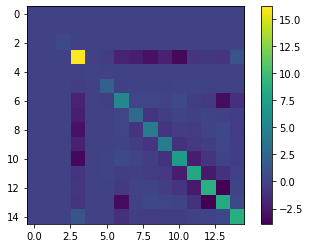

In [74]:
plt.imshow(A)
plt.colorbar()

In [34]:
error = A@GC.blank_cov@A.T - np.eye(GC.Ndim)

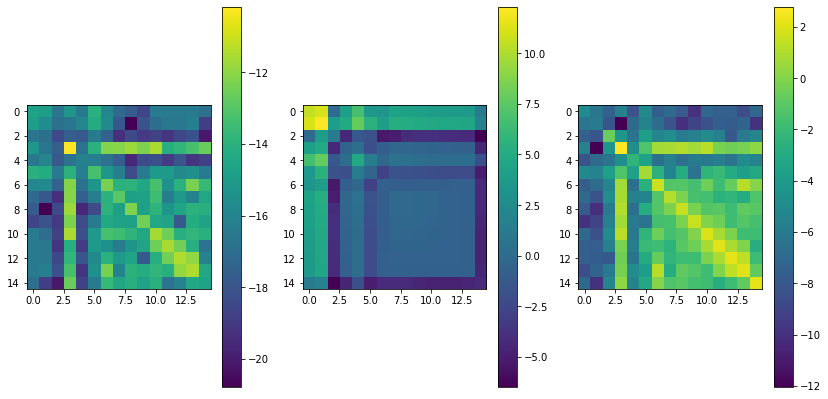

In [35]:
plt.figure(figsize=(14,7))
plt.subplot(1,3,1)
plt.imshow(np.log(np.abs(error)))
plt.colorbar()
plt.subplot(1,3,2)
plt.imshow(np.log(np.abs(GC.blank_cov)))
plt.colorbar()
plt.subplot(1,3,3)
plt.imshow(np.log(np.abs(A)))
plt.colorbar()


In [ ]:
# GC2._debug_f_vec_d.shape

In [ ]:
# f = plt.figure(figsize=(14,10))
# ax = f.gca()
# spec.plot_spread(GC2._debug_f_vec_d[:,-4:],.5);

In [125]:
import spectrotools as spec

(-5.0, 8.0)

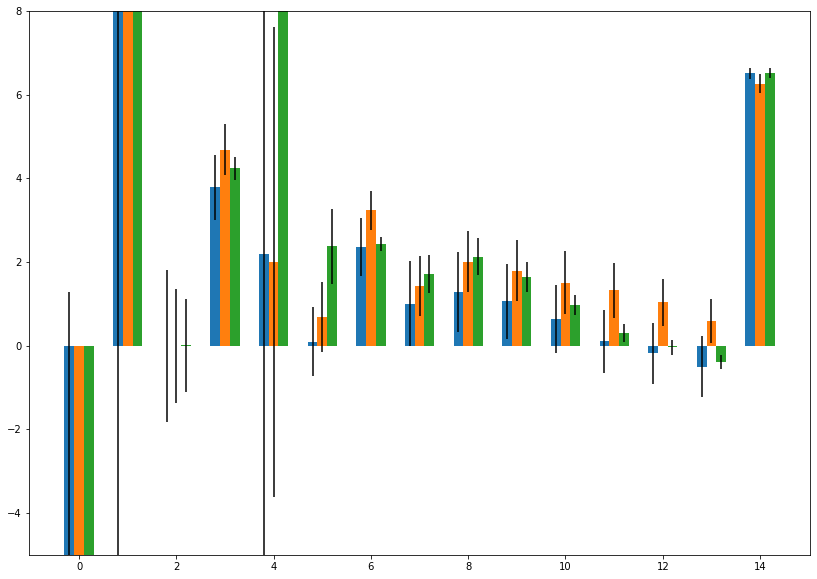

In [126]:
plt.figure(figsize=(14,10))
blank_std = np.sqrt(np.diag(GC.blank_cov))
class_std0 = np.sqrt(np.diag(GC.class_cov[0]))
class_std1 = np.sqrt(np.diag(GC.class_cov[1]))
# plt.plot(GC.blank_means[:],'k')
# plt.plot(GC.blank_means[:]+blank_std,'k:')
# plt.plot(GC.blank_means[:]-blank_std,'k:')
# plt.ylim([-10,10])
# plt.plot(GC.class_means[0,:],'b')
# plt.plot(GC2.class_means[0,:],'b:')
plt.bar(np.arange(GC.Ndim)-.2,GC.blank_means[:],yerr=blank_std,width=.2)
plt.bar(np.arange(GC.Ndim),GC.class_means[0,:],yerr=class_std0,width=.2)
plt.bar(np.arange(GC.Ndim)+.2,GC.class_means[1,:],yerr=class_std1,width=.2)
plt.ylim([-5,8])

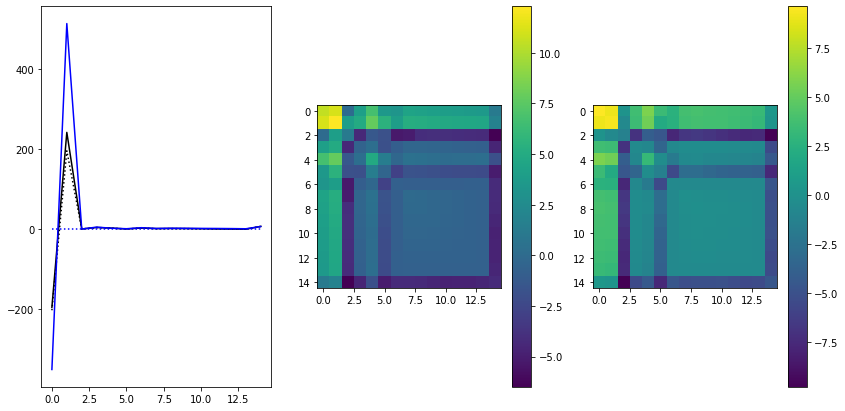

In [22]:
plt.figure(figsize=(14,7))
plt.subplot(1,3,1)
plt.plot(GC.blank_means,'k')
plt.plot(GC2.blank_means,'k:')
plt.plot(GC.class_means[0,:],'b')
plt.plot(GC2.class_means[0,:],'b:')
plt.subplot(1,3,2)
plt.imshow(np.log(np.abs(GC.blank_cov)))
plt.colorbar()
plt.subplot(1,3,3)
plt.imshow(np.log(np.abs(GC2.blank_cov)))
plt.colorbar()


In [149]:
project.animal_list[1].id

'h5_120'

In [103]:
(LLv,R2v,pf,timev) = GC.classify_animal(project.current_animal,100)

../pyecog2/classifier.py:24: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, F))
  LL[i] =( scale - 0.5*(fdata[i,:]-mu)@(inv_cov[:,:] @(fdata[i,:]-mu).T))[0,0]  # the [0,0] is for numba wizzardry to work
/home/mfpleite/anaconda3/envs/pyecog2/lib/python3.8/site-packages/numba-0.52.0-py3.8-linux-x86_64.egg/numba/core/typing/npydecl.py:933: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, F))
  warnings.warn(NumbaPerformanceWarning(msg))


Animal: h5_119 file: 1709 of 1710 /media/mfpleite/LaCie_1/ML_pyecog_2/data_from_ele/h5_119/M1572561642_2019-10-31-22-40-42_tids_[119].fmetaedia/mfpleite/LaCie_1/ML_pyecog_2/data_from_ele/h5_119/M1566725424_2019-08-25-10-30-24_tids_[119].fmeta h5_119 file: 363 of 1710 /media/mfpleite/LaCie_1/ML_pyecog_2/data_from_ele/h5_119/M1567715424_2019-09-05-21-30-24_tids_[119].fmeta h5_119 file: 441 of 1710 /media/mfpleite/LaCie_1/ML_pyecog_2/data_from_ele/h5_119/M1567993759_2019-09-09-02-49-19_tids_[119].fmeta h5_119 file: 460 of 1710 /media/mfpleite/LaCie_1/ML_pyecog_2/data_from_ele/h5_119/M1568062159_2019-09-09-21-49-19_tids_[119].fmeta h5_119 file: 925 of 1710 /media/mfpleite/LaCie_1/ML_pyecog_2/data_from_ele/h5_119/M1569739759_2019-09-29-07-49-19_tids_[119].fmetafile: 1045 of 1710 /media/mfpleite/LaCie_1/ML_pyecog_2/data_from_ele/h5_119/M1570171759_2019-10-04-07-49-19_tids_[119].fmeta h5_119 file: 1085 of 1710 /media/mfpleite/LaCie_1/ML_pyecog_2/data_from_ele/h5_119/M1570315759_2019-10-05-23-

start,end,confidence 912027 912032 4.157949511876799
start,end,confidence 912550 912556 54.48334557169417
start,end,confidence 912621 912624 14.201209672682202
start,end,confidence 912835 912838 7.672826045939452
start,end,confidence 913508 913510 6.280755639673467
start,end,confidence 913744 913747 23.3700963340092
start,end,confidence 914346 914350 4.124130949882851
start,end,confidence 914500 914503 7.809077627382743
start,end,confidence 917388 917392 7.69893395729134
start,end,confidence 917413 917418 11.772357368766597
start,end,confidence 918071 918074 3.422252865297759
start,end,confidence 920183 920191 28.92291765540655
start,end,confidence 922261 922263 3.4846626051732477
start,end,confidence 935071 935075 34.421177639948525
start,end,confidence 936265 936268 20.320912451868868
start,end,confidence 936945 936947 1.6226500095778615
start,end,confidence 937518 937522 16.47734215521795
start,end,confidence 937655 937662 30.243850090700892
start,end,confidence 938417 938419 7.3278

start,end,confidence 1856318 1856328 7.404309907129802
start,end,confidence 1856558 1856570 52.01617196648198
start,end,confidence 1857676 1857689 40.0773035426008
start,end,confidence 1860093 1860098 76.4231891085366
start,end,confidence 1860982 1860998 21.791043183132494
start,end,confidence 1861303 1861319 108.42521118345798
start,end,confidence 1861473 1861480 5.430884355379122
start,end,confidence 1862429 1862434 9.8278637727905
start,end,confidence 1863062 1863069 27.76955024958634
start,end,confidence 1863806 1863834 238.8525366883125
start,end,confidence 1864058 1864072 106.7387266029346
start,end,confidence 1864089 1864098 37.228808489588324
start,end,confidence 1864253 1864298 478.8406253556491
start,end,confidence 1864501 1864514 101.912576892203
start,end,confidence 1864604 1864618 34.32245422510289
start,end,confidence 1864642 1864670 91.32032726323133
start,end,confidence 1864822 1864850 350.10567374904537
start,end,confidence 1864916 1864955 292.7634895480508
start,end,c

add annotation
(auto)seizure None ['seizure', 'repeated IIEDs', '(auto)repeated IIEDs', '(auto)seizure']
Annotations: Label already exists
add annotation
(auto)seizure None ['seizure', 'repeated IIEDs', '(auto)repeated IIEDs', '(auto)seizure']
Annotations: Label already exists
add annotation
(auto)seizure None ['seizure', 'repeated IIEDs', '(auto)repeated IIEDs', '(auto)seizure']
Annotations: Label already exists
add annotation
(auto)seizure None ['seizure', 'repeated IIEDs', '(auto)repeated IIEDs', '(auto)seizure']
Annotations: Label already exists
add annotation
(auto)seizure None ['seizure', 'repeated IIEDs', '(auto)repeated IIEDs', '(auto)seizure']
Annotations: Label already exists
add annotation
(auto)seizure None ['seizure', 'repeated IIEDs', '(auto)repeated IIEDs', '(auto)seizure']
Annotations: Label already exists
add annotation
(auto)seizure None ['seizure', 'repeated IIEDs', '(auto)repeated IIEDs', '(auto)seizure']
Annotations: Label already exists
add annotation
(auto)seizur

start,end,confidence 12537 12542 41.486464026172385
start,end,confidence 12544 12546 0.9899051205623254
start,end,confidence 12585 12597 107.9853690777307
start,end,confidence 12612 12618 32.57310424379105
start,end,confidence 12619 12623 61.43613616342306
start,end,confidence 12652 12672 49.382045407054974
start,end,confidence 12781 12787 53.49059477905989
start,end,confidence 12817 12818 0.44222777499955085
start,end,confidence 12819 12833 312.31343460727226
start,end,confidence 12849 12857 70.37089084263249
start,end,confidence 12873 12874 0.1682767290408514
start,end,confidence 12876 12882 29.20977138665589
start,end,confidence 12904 12918 33.723034057657955
start,end,confidence 12936 12943 21.113950262914592
start,end,confidence 12947 12949 0.8155905513152756
start,end,confidence 12968 12970 1.363129646086098
start,end,confidence 12971 12975 4.692579791697115
start,end,confidence 13033 13061 632.1228276613601
start,end,confidence 13065 13072 126.78687514796113
start,end,confidence

start,end,confidence 123738 123740 8.53911543637554
start,end,confidence 123752 123754 5.025257020309977
start,end,confidence 123795 123804 77.12179051683586
start,end,confidence 123805 123806 3.488159822837795
start,end,confidence 123809 123817 96.60587107590186
start,end,confidence 123865 123870 3.4847878364549176
start,end,confidence 123884 123886 2.866396806506198
start,end,confidence 123912 123917 4.352933262859347
start,end,confidence 123933 123935 3.03473579570818
start,end,confidence 123955 123956 4.797691766238289
start,end,confidence 123969 123972 1.8315530885987261
start,end,confidence 123987 123992 37.694839911169296
start,end,confidence 124239 124243 12.541175557862143
start,end,confidence 124259 124261 4.6054818364624674
start,end,confidence 124546 124549 25.955606267500837
start,end,confidence 124911 124913 1.5879869745171873
start,end,confidence 126748 126777 659.2888354863172
start,end,confidence 126778 126782 80.79156601474276
start,end,confidence 126783 126796 289.06

start,end,confidence 189072 189075 65.83857724527266
start,end,confidence 189078 189090 250.0321465010266
start,end,confidence 189091 189092 9.868388204250984
start,end,confidence 189093 189100 146.5485784244666
start,end,confidence 189101 189103 13.612705837879227
start,end,confidence 189104 189116 289.91949115445516
start,end,confidence 189117 189124 71.55439103202343
start,end,confidence 189135 189139 31.405307409643594
start,end,confidence 189141 189145 57.532486413840076
start,end,confidence 189146 189150 61.98414529631664
start,end,confidence 189154 189169 237.50934307508788
start,end,confidence 189171 189175 24.53437568561956
start,end,confidence 189177 189179 5.027084463729535
start,end,confidence 189180 189190 96.82210109785214
start,end,confidence 189223 189226 10.389550700179784
start,end,confidence 189227 189229 4.314905791634139
start,end,confidence 189242 189246 17.468504511675917
start,end,confidence 189286 189288 14.072470499405377
start,end,confidence 189289 189291 11.

start,end,confidence 236466 236480 308.72977717909566
start,end,confidence 236481 236527 1163.8724990735675
start,end,confidence 236529 236533 20.373191406173696
start,end,confidence 236534 236544 164.59742811709336
start,end,confidence 236632 236639 103.0967538851815
start,end,confidence 236828 236838 30.939424168980054
start,end,confidence 236895 236920 558.3792822952541
start,end,confidence 236921 236928 66.57795007954026
start,end,confidence 236929 236946 277.1528124154888
start,end,confidence 237033 237040 37.55204369953543
start,end,confidence 237184 237188 28.67914988163144
start,end,confidence 237200 237202 15.669442449747194
start,end,confidence 237209 237218 145.83822574275382
start,end,confidence 237223 237235 202.89251652837387
start,end,confidence 237236 237238 31.13134622168056
start,end,confidence 237239 237247 68.10606126559442
start,end,confidence 237248 237256 167.89226569216495
start,end,confidence 237259 237264 18.640506106127695
start,end,confidence 237265 237275 2

start,end,confidence 282094 282109 150.051374878686
start,end,confidence 282127 282134 25.00842798974776
start,end,confidence 282159 282184 310.4179505226541
start,end,confidence 282223 282225 8.228182330165588
start,end,confidence 282238 282241 9.216508781965949
start,end,confidence 282324 282331 5.586902255072065
start,end,confidence 282750 282752 1.533639836478562
start,end,confidence 282792 282794 1.3766064170253827
start,end,confidence 282836 282839 4.1390390499048255
start,end,confidence 282862 282864 13.187492792625477
start,end,confidence 282934 282940 11.449400533937544
start,end,confidence 282992 282993 0.27593883046165285
start,end,confidence 282995 282997 13.266126995316668
start,end,confidence 284974 284976 2.2353977829509555
start,end,confidence 284998 285000 23.140523744552613
start,end,confidence 285144 285151 28.99981354859343
start,end,confidence 285154 285156 13.093661529366463
start,end,confidence 285657 285662 53.90925280729612
start,end,confidence 285849 285850 0.

start,end,confidence 338645 338652 14.608974876378621
start,end,confidence 338674 338676 5.865933384012472
start,end,confidence 338686 338689 9.411129352661169
start,end,confidence 338690 338691 7.924502479568073e-08
start,end,confidence 338715 338718 3.595082468194114
start,end,confidence 338761 338767 68.42018753452746
start,end,confidence 339430 339434 3.334380122755763
start,end,confidence 339861 339868 12.127385334176946
start,end,confidence 339883 339886 28.087589698736068
start,end,confidence 339888 339890 47.74228262091971
start,end,confidence 339892 339921 754.6090821787088
start,end,confidence 339924 339942 320.70041468440587
start,end,confidence 339943 339944 27.631021115928547
start,end,confidence 339946 339948 14.16829380039296
start,end,confidence 339954 339956 6.015003776437827
start,end,confidence 339957 339963 103.25324394718021
start,end,confidence 339972 339976 42.275520053966716
start,end,confidence 339979 339981 8.659261543794873
start,end,confidence 339982 339989 

start,end,confidence 439476 439481 50.69985437411694
start,end,confidence 439488 439505 300.54728673061504
start,end,confidence 439506 439521 262.052866550862
start,end,confidence 439523 439557 609.9634998538387
start,end,confidence 439558 439562 48.5560849588602
start,end,confidence 439567 439581 138.8021516024871
start,end,confidence 439592 439621 441.5593088335671
start,end,confidence 439634 439641 6.868590417993765
start,end,confidence 439779 439800 301.0320392515539
start,end,confidence 439801 439808 39.919049602501374
start,end,confidence 439819 439828 18.122929060405067
start,end,confidence 439841 439849 87.040260905888
start,end,confidence 439861 439866 25.931482860179074
start,end,confidence 439922 439949 433.00200730262577
start,end,confidence 439998 440000 1.7187337135871352
start,end,confidence 440003 440015 75.31798671952689
start,end,confidence 440024 440039 114.70186386213751
start,end,confidence 440043 440061 315.82957531404844
start,end,confidence 440062 440063 2.63052

start,end,confidence 556498 556501 26.998895179892653
start,end,confidence 557049 557050 0.017292494665784267
start,end,confidence 557165 557182 340.1604021391441
start,end,confidence 557183 557185 33.26967223385793
start,end,confidence 557186 557195 214.71395646421598
start,end,confidence 557198 557199 2.7490259232662395
start,end,confidence 557216 557218 4.3660879192354605
start,end,confidence 557219 557221 10.448900604157615
start,end,confidence 557222 557225 27.677358137523
start,end,confidence 557226 557227 13.246504076085492
start,end,confidence 557230 557234 45.79761303786357
start,end,confidence 557235 557238 32.98633155234789
start,end,confidence 557243 557253 54.45524831017025
start,end,confidence 557272 557274 7.314638009041649
start,end,confidence 557292 557299 128.11204511129415
start,end,confidence 557350 557358 148.0209953919348
start,end,confidence 557360 557371 230.69790616720968
start,end,confidence 557372 557382 217.8393681212486
start,end,confidence 557383 557389 10

start,end,confidence 652544 652547 38.356865764390044
start,end,confidence 652549 652555 31.102064621114245
start,end,confidence 652706 652725 289.25603386248054
start,end,confidence 652944 652946 4.392363615291111
start,end,confidence 652947 652955 94.245409040249
start,end,confidence 653910 653920 118.99303594517386
start,end,confidence 653938 653939 0.0
start,end,confidence 653940 653952 306.79042188770563
start,end,confidence 653970 653977 72.98667095754504
start,end,confidence 653978 653981 14.829416031275649
start,end,confidence 653983 653985 32.81832605968481
start,end,confidence 653994 653999 91.30925043524749
start,end,confidence 654000 654001 14.049388641252595
start,end,confidence 654002 654006 55.98909497536589
start,end,confidence 654007 654008 13.410762996800688
start,end,confidence 654009 654013 44.94867906529261
start,end,confidence 654014 654027 264.91090129654987
start,end,confidence 654028 654038 188.10954766880843
start,end,confidence 654039 654041 34.47040645961692

start,end,confidence 708978 708986 156.81151685757686
start,end,confidence 708995 709011 280.8416600276507
start,end,confidence 709012 709013 3.131748592136277
start,end,confidence 709019 709028 175.3331001604349
start,end,confidence 709029 709033 82.89310564001532
start,end,confidence 709034 709041 115.15185269145884
start,end,confidence 709042 709045 45.05112892508136
start,end,confidence 709046 709050 54.68398318799324
start,end,confidence 709052 709062 215.68931882941627
start,end,confidence 709063 709075 144.40421349756662
start,end,confidence 709694 709698 38.80480005058397
start,end,confidence 710928 710932 14.826313001889009
start,end,confidence 710937 710939 3.929258723293545
start,end,confidence 711701 711713 51.06590953020089
start,end,confidence 711937 711938 0.0
start,end,confidence 712216 712222 17.124433771919588
start,end,confidence 714209 714211 27.51271108443526
start,end,confidence 715478 715479 8.274986100627915e-07
start,end,confidence 715499 715502 19.321411738025

start,end,confidence 807159 807161 11.057855788525552
start,end,confidence 807167 807169 16.184913563873394
start,end,confidence 807183 807191 12.357030523605271
start,end,confidence 807201 807203 1.8907141714435418
start,end,confidence 807330 807348 92.27528820663359
start,end,confidence 807491 807493 27.636250023897276
start,end,confidence 807523 807525 1.391865823263166
start,end,confidence 807854 807858 3.1223687894378815
start,end,confidence 807869 807887 314.49452910902926
start,end,confidence 807888 807891 24.529678589800213
start,end,confidence 809378 809379 1.873039275149157e-05
start,end,confidence 810377 810381 24.81230002173472
start,end,confidence 810691 810693 2.4421201933126704
start,end,confidence 811375 811377 18.311922088318102
start,end,confidence 811888 811890 2.944803499741841
start,end,confidence 812064 812066 17.906017553755415
start,end,confidence 812975 812977 9.184840748747257
start,end,confidence 812978 812979 27.631021115928547
start,end,confidence 813350 81

start,end,confidence 949999 950000 0.3922747716551116
start,end,confidence 950078 950079 2.6647784151768398e-06
start,end,confidence 951032 951034 24.59720032277289
start,end,confidence 952324 952326 15.298944239182775
start,end,confidence 953269 953271 1.362851511638786
start,end,confidence 953982 953987 10.216986420513864
start,end,confidence 954303 954315 252.02157309870591
start,end,confidence 954316 954319 67.143778362836
start,end,confidence 954320 954337 449.78903398054746
start,end,confidence 954338 954340 53.99195831967873
start,end,confidence 954342 954354 326.22067144066705
start,end,confidence 954355 954356 21.075867824067377
start,end,confidence 954357 954363 152.7378435909358
start,end,confidence 954364 954384 537.8077369011934
start,end,confidence 954385 954386 4.723806609883258
start,end,confidence 954387 954388 0.532657903907879
start,end,confidence 954389 954397 169.42771451169028
start,end,confidence 954398 954417 507.1214323728144
start,end,confidence 954418 954419 

start,end,confidence 1461688 1461689 3.288242973943669
start,end,confidence 1462217 1462222 8.73396423256099
start,end,confidence 1463925 1463933 28.47859742716708
start,end,confidence 1477697 1477701 3.8110579859490135
start,end,confidence 1483125 1483136 66.47993144576859
start,end,confidence 1483154 1483165 147.3361610710311
start,end,confidence 1483166 1483167 7.403575755861258
start,end,confidence 1483168 1483179 122.25590999598879
start,end,confidence 1483187 1483191 20.167424991831297
start,end,confidence 1483192 1483193 7.829374278369052
start,end,confidence 1483195 1483205 74.65194212748722
start,end,confidence 1483220 1483223 6.288958693215834
start,end,confidence 1483238 1483246 37.62070549654321
start,end,confidence 1483264 1483271 58.773417374856564
start,end,confidence 1483280 1483285 35.87235547775803
start,end,confidence 1483286 1483290 47.955794753969116
start,end,confidence 1483303 1483321 257.38898443371255
start,end,confidence 1483363 1483367 23.509044200638257
star

[(193.41920387154005, {'label': '(auto)repeated IIEDs', 'start': 1566409421.5, 'end': 1566409466.5, 'confidence': 193.41920387154005, 'notes': ''}), (25.158387034533714, {'label': '(auto)repeated IIEDs', 'start': 1566409591.5, 'end': 1566409594.0, 'confidence': 25.158387034533714, 'notes': ''}), (320.87266484692327, {'label': '(auto)repeated IIEDs', 'start': 1566409596.5, 'end': 1566409629.0, 'confidence': 320.87266484692327, 'notes': ''}), (81.79681686909102, {'label': '(auto)repeated IIEDs', 'start': 1566409631.5, 'end': 1566409641.5, 'confidence': 81.79681686909102, 'notes': ''}), (56.38842129420326, {'label': '(auto)repeated IIEDs', 'start': 1566409661.5, 'end': 1566409669.0, 'confidence': 56.38842129420326, 'notes': ''}), (151.3649396760644, {'label': '(auto)repeated IIEDs', 'start': 1566409674.0, 'end': 1566409691.5, 'confidence': 151.3649396760644, 'notes': ''}), (20.669088526134168, {'label': '(auto)repeated IIEDs', 'start': 1566409694.0, 'end': 1566409704.0, 'confidence': 20.6

In [16]:
(LLv,R2v,pf,timev) = GC2.classify_animal(project.animal_list[1],100)

../pyecog2/classifier.py:25: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, F))
  LL[i] =( scale - 0.5*(fdata[i,:]-mu)@(inv_cov[:,:] @(fdata[i,:]-mu).T))[0,0]  # the [0,0] is for numba wizzardry to work
/home/mfpleite/anaconda3/envs/pyecog2/lib/python3.8/site-packages/numba-0.52.0-py3.8-linux-x86_64.egg/numba/core/typing/npydecl.py:933: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, F))
  warnings.warn(NumbaPerformanceWarning(msg))


Animal: h5_120 file: 1691 of 1692 /media/mfpleite/LaCie_1/ML_pyecog_2/data_from_ele/h5_120/M1572561642_2019-10-31-22-40-42_tids_[120].fmetaf 1692 /media/mfpleite/LaCie_1/ML_pyecog_2/data_from_ele/h5_120/M1566977424_2019-08-28-08-30-24_tids_[120].fmeta197 of 1692 /media/mfpleite/LaCie_1/ML_pyecog_2/data_from_ele/h5_120/M1567182624_2019-08-30-17-30-24_tids_[120].fmeta h5_120 file: 355 of 1692 /media/mfpleite/LaCie_1/ML_pyecog_2/data_from_ele/h5_120/M1567751424_2019-09-06-07-30-24_tids_[120].fmeta
Running HMM...
HMM:forward
HMM:backward
Combining results and generating annotations...
1 seizure
len starts 187
manual label positions: []
start,end,confidence 1303 1304 1.5335594694067503
start,end,confidence 72290 72292 1.079222294041928
start,end,confidence 72384 72393 5.276421580623219
start,end,confidence 78777 78810 24.914172278585827
start,end,confidence 78971 78983 8.14784466952432
start,end,confidence 79272 79278 4.95009040937819
start,end,confidence 79285 79292 2.3930329707727056
star

start,end,confidence 67366 67370 10.377492955023587
start,end,confidence 67386 67389 2.780780528543721
start,end,confidence 67393 67401 27.631021115928547
start,end,confidence 67402 67412 23.963155304495082
start,end,confidence 67415 67419 9.119728536468468
start,end,confidence 67423 67431 20.61589606723817
start,end,confidence 67434 67443 18.666339180462373
start,end,confidence 67900 67905 12.245734587483804
start,end,confidence 68633 68635 2.916997148552879
start,end,confidence 68659 68660 10.221599315330725
start,end,confidence 68683 68685 9.521284598440529
start,end,confidence 68732 68736 27.631021115928547
start,end,confidence 68740 68744 27.631021115928547
start,end,confidence 68748 68749 0.04555690189480553
start,end,confidence 68754 68756 7.68743856028729
start,end,confidence 68758 68760 3.8360630077100817
start,end,confidence 68770 68772 3.509787067080395
start,end,confidence 68774 68777 25.322944340919157
start,end,confidence 68779 68782 23.479965741641266
start,end,confidenc

start,end,confidence 627728 627729 11.01346431796731
start,end,confidence 627731 627732 8.52920549970709
start,end,confidence 627739 627746 27.631021115928547
start,end,confidence 627747 627748 7.247135955363254
start,end,confidence 627758 627761 23.811464754234212
start,end,confidence 627766 627768 11.214881441636706
start,end,confidence 627774 627776 23.454991981813123
start,end,confidence 627780 627783 24.375948870359373
start,end,confidence 627788 627790 3.6936349761834437
start,end,confidence 627792 627793 13.927577339021418
start,end,confidence 627794 627796 27.61551001453443
start,end,confidence 627797 627799 13.149198869869368
start,end,confidence 627801 627802 2.4150101828696924
start,end,confidence 627806 627807 0.0002869870372215153
start,end,confidence 627808 627813 22.754283466641187
start,end,confidence 627814 627827 27.631021115928547
start,end,confidence 627829 627839 27.631021115928547
start,end,confidence 627854 627858 27.631021115928547
start,end,confidence 627873 62

In [ ]:
# project.save_to_json(fname = project.project_file[:-7]+'_test.pyecog')

<ipython-input-70-b0a097fda800>:2: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(pf.T)-np.log(1-pf.T),'.', markersize=1)


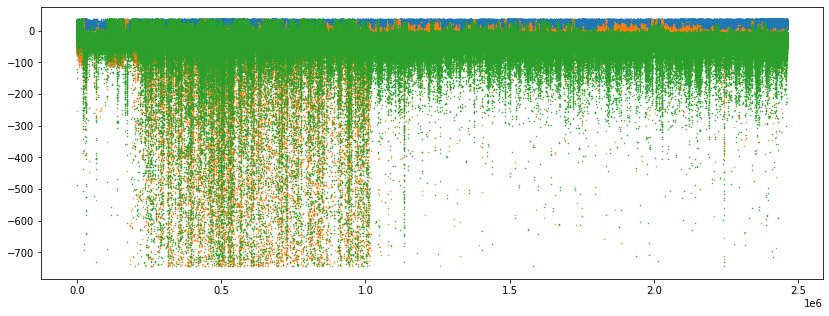

In [70]:
plt.figure(figsize=(14,5))
plt.plot(np.log(pf.T)-np.log(1-pf.T),'.', markersize=1)
# plt.ylim(-100,50)

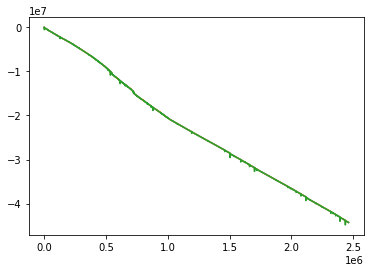

In [71]:
plt.plot(GC.hmm.alpha.T)
# plt.plot(GC.hmm.beta.T)

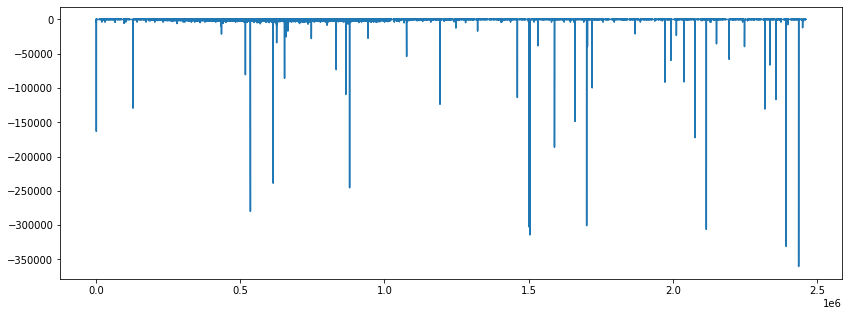

In [72]:
plt.figure(figsize=(14,5))
plt.plot(LLv[:,1]-LLv[:,0], markersize=1)
plt.plot(np.where(np.isfinite(LLv[:,1]-LLv[:,0]),np.nan,1),'*')

plt.plot(np.where(np.isfinite(LLv[:,0]),np.nan,20000),'*')
plt.plot(np.where(np.isfinite(LLv[:,1]),np.nan,10000),'*')

In [27]:
print(GC.hmm.A)
print(GC.hmm.phi)

[[9.99997562e-01 2.43796794e-06]
 [4.22535211e-02 9.57746479e-01]]
[[ -247.60718107  -247.51882057  -247.83037244 ...   -12.64143888
    -13.13367215   -60.14581098]
 [-4102.65662991 -4157.71035082 -4092.1385822  ...   -21.2091908
    -20.00942799   -33.10859413]]


In [28]:
GC.hmm.alpha.dtype

dtype('float64')

(-1000.0, 1000.0)

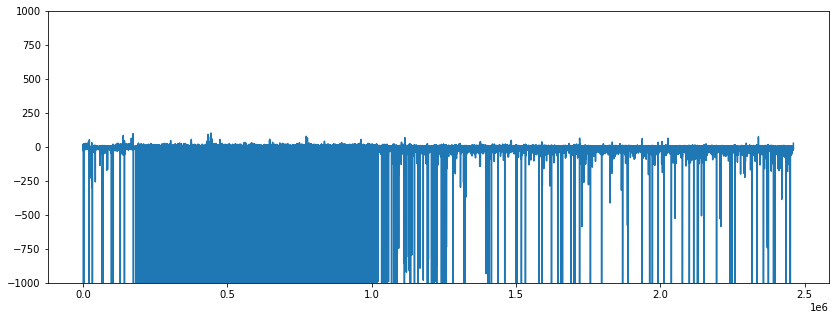

In [29]:
plt.figure(figsize=(14,5))
plt.plot(LLv[:,1]-LLv[:,0], markersize=1)
plt.ylim(-1000,1000)

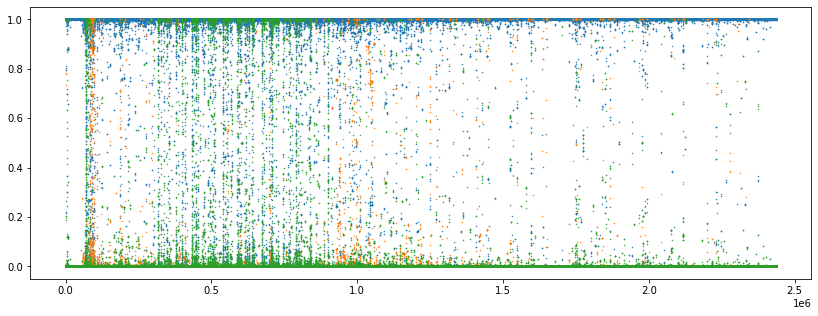

In [21]:
plt.figure(figsize=(14,5))
plt.plot(pf.T,'.', markersize=1)

<ipython-input-20-1aa7656eef08>:2: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(pf.T)-np.log(np.maximum(1-pf.T,1e-12)),'.', markersize=1)


(-100.0, 50.0)

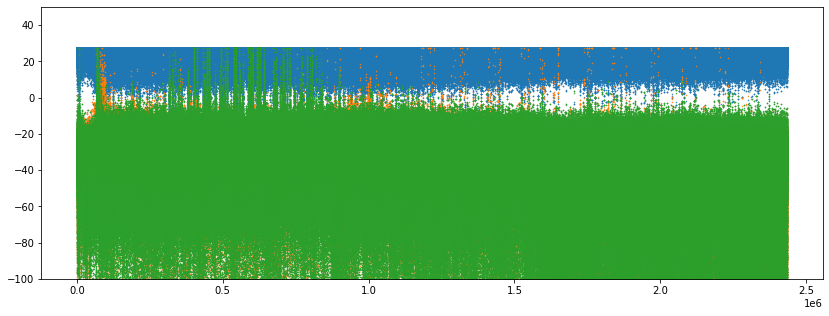

In [20]:
plt.figure(figsize=(14,5))
plt.plot(np.log(pf.T)-np.log(np.maximum(1-pf.T,1e-12)),'.', markersize=1)
plt.ylim(-100,50)

In [32]:
np.log(np.maximum(1-pf.T,1e-12))

array([[-2.76310211e+01,  0.00000000e+00],
       [-2.76310211e+01,  0.00000000e+00],
       [-2.76310211e+01,  0.00000000e+00],
       ...,
       [-1.55306545e+01, -1.79937837e-07],
       [-6.91973280e+00, -9.88582414e-04],
       [-7.42040096e-07, -1.41138629e+01]])

In [152]:
project.current_animal.annotations.labels

['seizure', 'repeated IIEDs', '(auto)seizure']

In [153]:
len(project.current_animal.annotations.annotations_list)

102

In [17]:
project.project_file[:-7]

'/media/mfpleite/LaCie_1/ML_pyecog_2/AwesomeProject_IIEDs'

In [18]:
project.save_to_json(fname = project.project_file[:-7]+'_test.pyecog')

In [149]:
# f_vec_d = np.hstack([f_vec, np.vstack([np.zeros(f_vec.shape[1]), np.diff(f_vec, axis=0)])])
LL = GC.log_likelyhoods(f_vec,bias=True,no_scale=False)

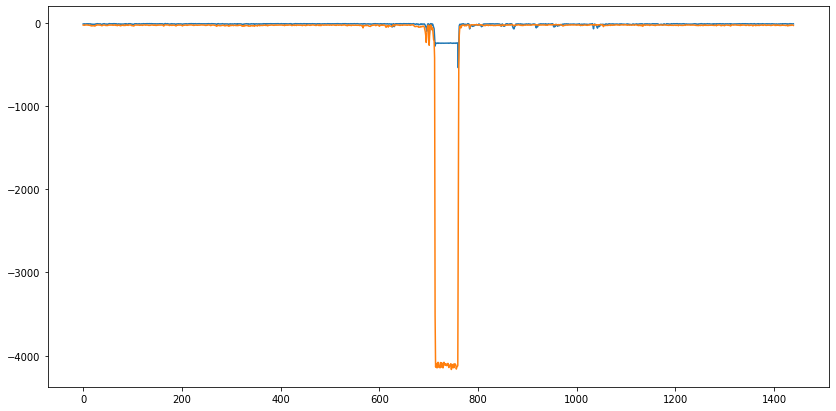

In [150]:
plt.figure(figsize=(14,7))
plt.plot(LL)

In [620]:
print(np.linalg.det(blanks_cov),np.linalg.det(GC.class_cov[0]))

0.000582672948028742 0.28223231073679556


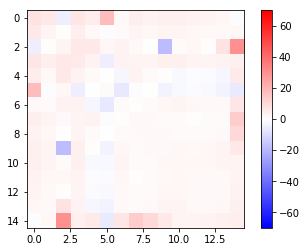

In [621]:
plt.imshow(GC.class_cov[0]/blanks_cov,cmap='bwr',vmin=-70,vmax=70)
plt.colorbar()

In [622]:
@jit(nopython=True)
def LL2prob_jit(LL,prob):
    for i in range(LL.shape[0]):
        v = np.exp(LL[i,:])
        prob[i,:] = v / np.sum(v)
        
def LL2prob(LL):
    prob = np.zeros(LL.shape)
    LL2prob_jit(LL,prob)
    return prob

In [623]:
p = LL2prob(LL)

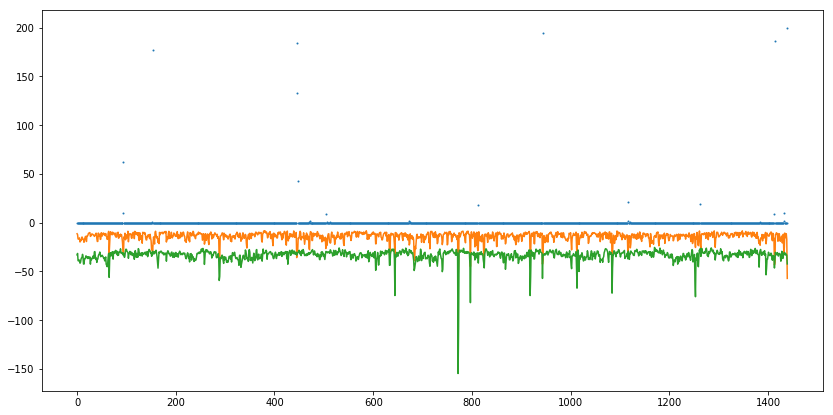

In [624]:
plt.figure(figsize=(14,7))
plt.plot(p[:,1]*200,'.',markersize=2)
plt.plot(LL[:,0])
# plt.plot(b_LLr)
plt.plot(LL[:,1])
# plt.plot(s_LLr)
# plt.vlines(starts[1:],-1000,0,linestyles=':')
# plt.vlines(ends[1:],-1000,0,linestyles=':')
# plt.xlim(400,1000)/

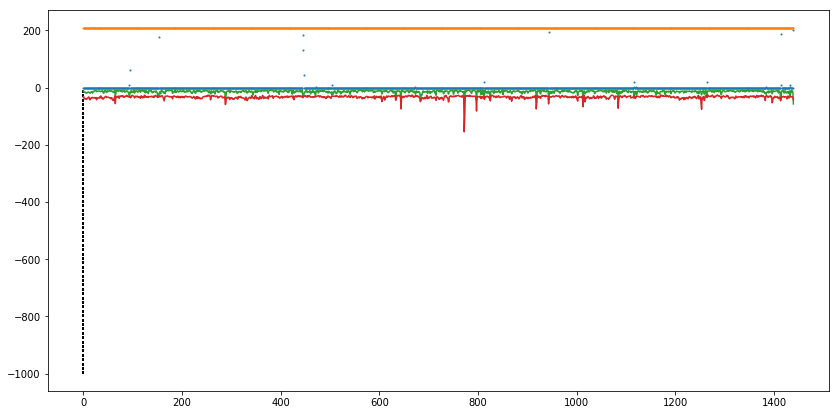

In [625]:
plt.figure(figsize=(14,7))
plt.plot(p[:,1]*200,'.',markersize=2)
plt.plot(p[:,2]*200+210,'.',markersize=2)
plt.plot(LL[:,0])
# plt.plot(b_LLr)
plt.plot(LL[:,1])
# plt.plot(s_LLr)
plt.vlines(starts[1:],-1000,0,linestyles=':')
plt.vlines(ends[1:],-1000,0,linestyles=':')
# plt.xlim(400,1000)/

In [699]:
LLv = []
R2v = []
drawplots = False

project.current_animal.eeg_files.sort()
for eegfname in project.current_animal.eeg_files:
    fname = '.'.join(eegfname.split('.')[:-1]+['features'])
    f_vec = np.fromfile(fname,dtype='float64')
    f_vec = f_vec.reshape((-1,fe.settings['number_of_features']))
#     f_vec = np.hstack([f_vec, np.vstack([np.zeros(f_vec.shape[1]), np.diff(f_vec, axis=0)])])
    LL = GC.log_likelyhoods(f_vec,bias=False,no_scale=False)
    R2 = GC.log_likelyhoods(f_vec,bias=False,no_scale=True)
    LLv.append(LL)
    R2v.append(R2)
    p  = LL2prob(LL) 
    if drawplots:
        plt.figure(figsize=(14,7))
        plt.plot(p[:,1]*200,'.',markersize=2)
        plt.plot(LL[:,0],'.',markersize=2)
        plt.plot(LL[:,1],'.',markersize=2)
        plt.vlines(starts[1:],-1000,0,linestyles=':')
        plt.vlines(ends[1:],-1000,0,linestyles=':')
        plt.title(eegfname)
        plt.show()
    # plt.xlim(400,1000)

    
LLv = np.vstack(LLv)
R2v = np.vstack(R2v)
pv  = LL2prob(LLv) 

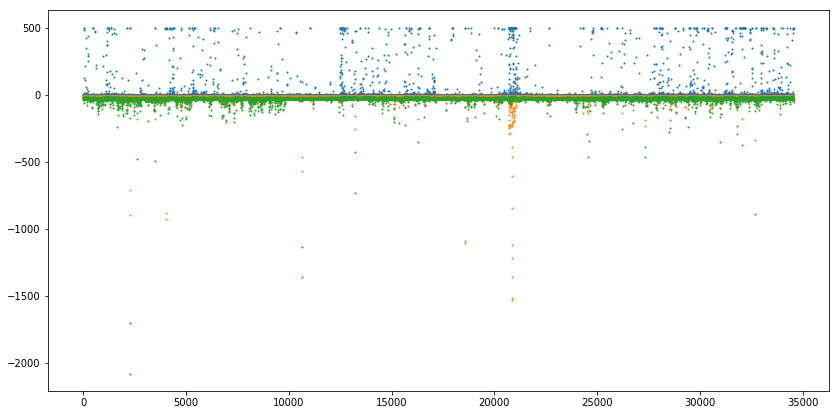

In [700]:
plt.figure(figsize=(14,7))
plt.plot(pv[:,1]*500,'.',markersize=2)
plt.plot(LLv[:,0],'.',markersize=2)
plt.plot(LLv[:,1],'.',markersize=2)
# plt.vlines(starts[1:],-1000,0,linestyles=':')
# plt.vlines(ends[1:],-1000,0,linestyles=':')

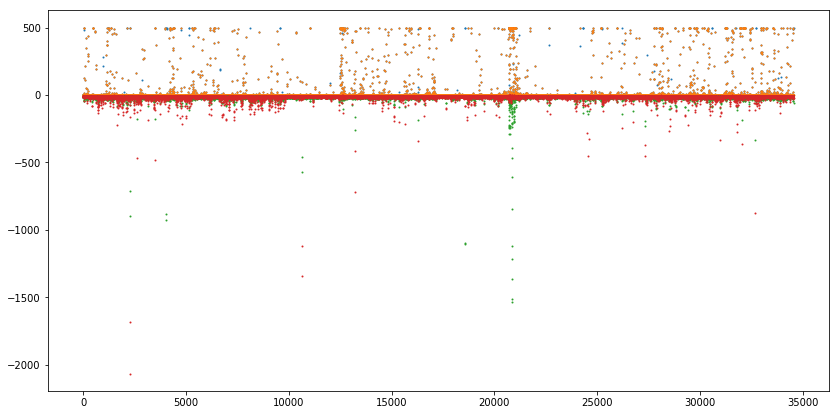

In [701]:
th = stats.chi2.isf(1e-3,15,scale=0.5)
plt.figure(figsize=(14,7))


plt.plot(pv[:,1]*500,'.',markersize=2)
plt.plot((pv[:,1]*(-R2v[:,1]<th))*500,'.',markersize=2)
# plt.plot((-R2v[:,1]<th)*500,'-',markersize=2)
plt.plot(R2v[:,0],'.',markersize=2)
plt.plot(R2v[:,1],'.',markersize=2)

In [645]:
@jit(nopython=True)
def LL2prob_jit(LL,prob):
    for i in range(LL.shape[0]):
        v = np.exp(LL[i,:])
        prob[i,:] = v / np.sum(v)
        
def LL2prob(LL):
    prob = np.zeros(LL.shape)
    LL2prob_jit(LL,prob)
    return prob

In [646]:
import hmm_pyecog
importlib.reload(hmm_pyecog)

<module 'hmm_pyecog' from '../hmm_pyecog.py'>

In [647]:
# HMM = hmm_pyecog.HMM_LL()
HMM = GC.hmm

In [649]:
HMM.A

array([[9.99956519e-01, 4.34807815e-05, 0.00000000e+00],
       [4.83870968e-02, 9.51612903e-01, 0.00000000e+00],
       [1.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [702]:
p  = LL2prob(LLv).T
pf = HMM.forward_backward(LLv.T)
starts = np.diff(((pf[1,:].T*(-R2v[:,1]<th)))>.5)>0
ends =  np.diff(((pf[1,:].T*(-R2v[:,1]<th))>.5).astype('int'))<0

../hmm_pyecog.py:245: RuntimeWarning: divide by zero encountered in log
  alpha[:, 0] = log_phi[:, 0] + np.log(stationary_dist)
../hmm_pyecog.py:249: RuntimeWarning: divide by zero encountered in log
  alpha_t = log_phi[:, t] + np.log(np.dot(exp_alpha_t.T, A))  # sure no undeflow here...
../hmm_pyecog.py:284: RuntimeWarning: divide by zero encountered in log
  beta[:, t] = np.log(beta_t) + max_beta_t


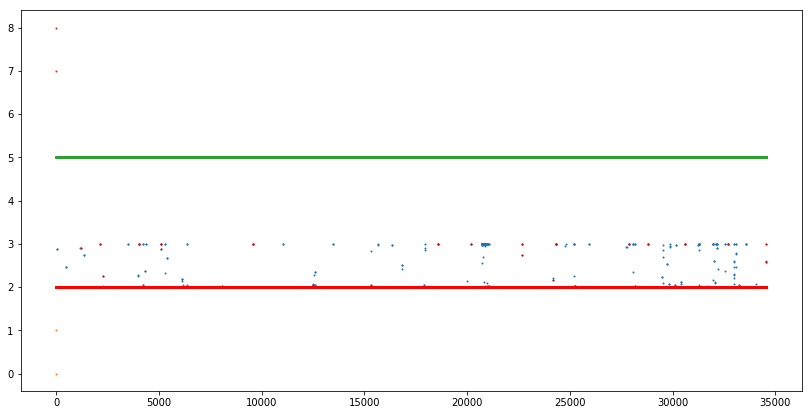

In [753]:
plt.figure(figsize=(14,7))
plt.plot(pf[1,:].T+2,'.',markersize=2)
plt.plot((pf[1,:].T*(-R2v[:,1]>th))+2,'r.',markersize=2)
plt.plot(p[1,:].T,'.',markersize=2)
plt.plot(pf[2,:].T+5,'.',markersize=2)
plt.plot(p[2,:].T+7,'.',markersize=2)
# plt.plot(p[1,:].T-pf[1,:].T-2,'.',markersize=2)

th = stats.chi2.isf(1e-3,15,scale=0.5)
# plt.xlim(20000,22050)

In [754]:
np.sum(np.diff((pf[1,:]>.5).astype('int')>0))


123

In [755]:
starts = np.nonzero(np.diff(((pf[1,:].T*(-R2v[:,1]<th))>.5).astype('int'))>0)[0]
ends =   np.nonzero(np.diff(((pf[1,:].T*(-R2v[:,1]<th))>.5).astype('int'))<0)[0]

In [756]:
len(starts)

55

In [757]:
np.tile(np.eye(10),(5,1,1)).shape

(5, 10, 10)

(20600, 21500)

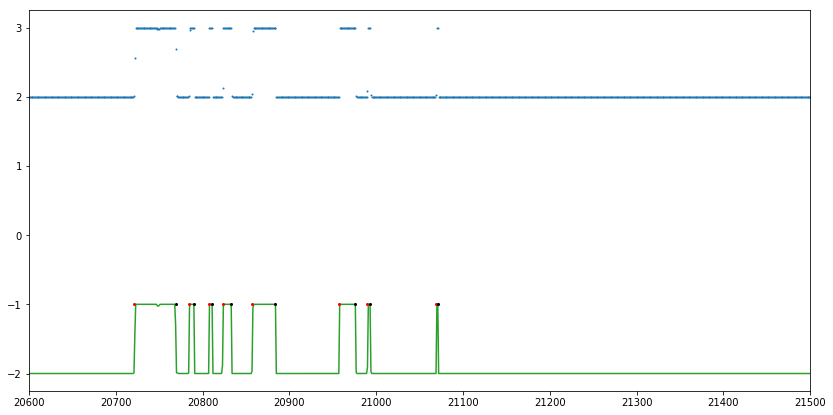

In [759]:
r = (20600,21500)

plt.figure(figsize=(14,7))
plt.plot(pf[1,:].T+2,'.',markersize=2)
plt.plot(p[1,:].T,'.',markersize=2)
# plt.plot(p[1,:].T-pf[1,:].T-2,'.',markersize=2)

th = stats.chi2.isf(1e-3,15,scale=0.5)
plt.plot((pf[1,:].T*(-R2v[:,1]<th))-2,'-',markersize=2)
plt.plot(starts,starts*0-1,'o',markersize=2,color='r')
plt.plot(ends,ends*0-1,'o',markersize=2,color='k')
plt.xlim(*r)

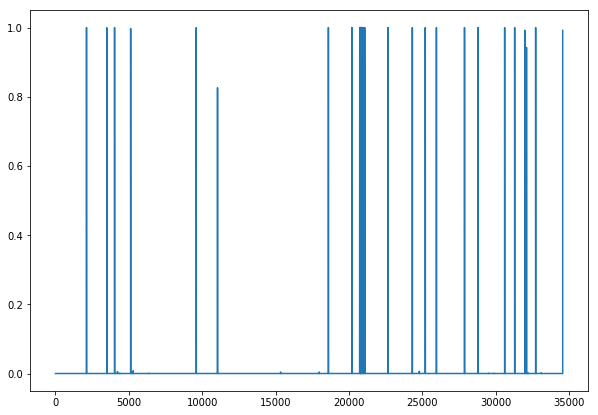

In [125]:
plt.figure(figsize=(10,7))
plt.plot(pf[1,:])
plt.show()

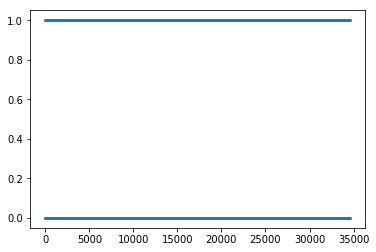

In [126]:
th = stats.chi2.isf(1e-1,15,scale=0.5)
plt.plot((-R2v[:,1]<th),'.',markersize=2)

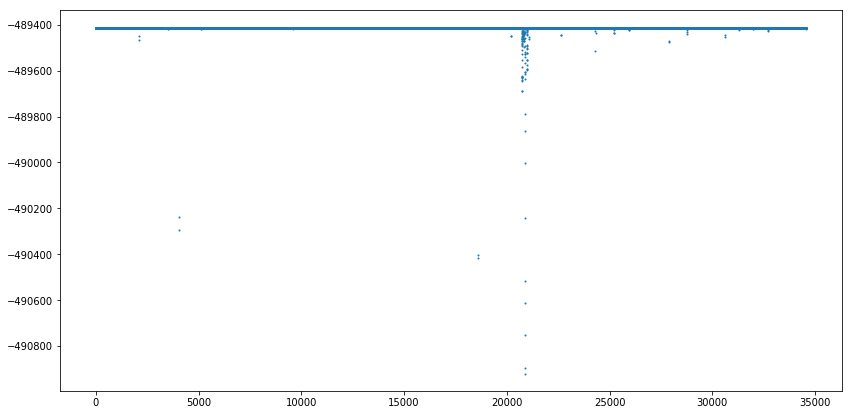

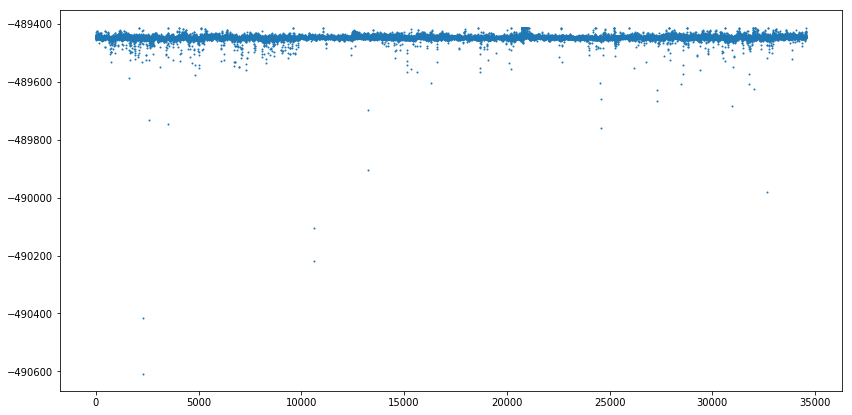

In [127]:

plt.figure(figsize=(14,7))
plt.plot((HMM.alpha[0,:] + HMM.beta[0,:]).T,'.',markersize=2)
plt.figure(figsize=(14,7))
plt.plot((HMM.alpha[1,:] + HMM.beta[1,:]).T,'.',markersize=2)

(20000, 22000)

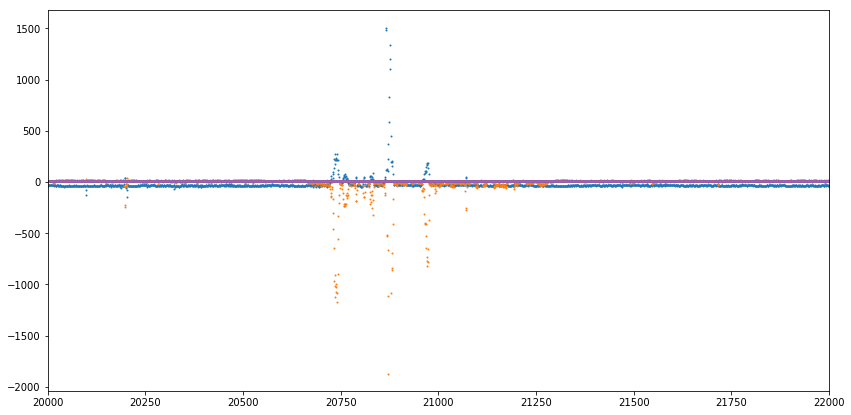

In [128]:
plt.figure(figsize=(14,7))
plt.plot(np.diff(HMM.beta.T+HMM.alpha.T,axis=1),'.',markersize=2)

plt.plot(HMM.posterior.T+10,'.',markersize=2)
plt.xlim(20000,22000)

/home/mfpleite/anaconda3/envs/pyecog2_env/lib/python3.5/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/home/mfpleite/anaconda3/envs/pyecog2_env/lib/python3.5/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


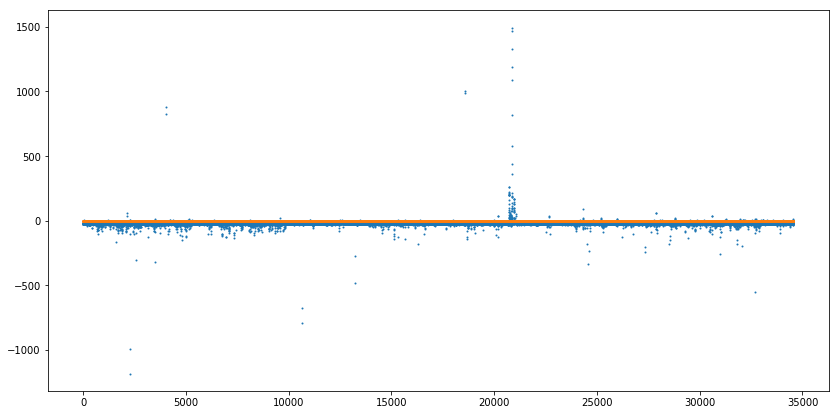

In [129]:
plt.figure(figsize=(14,7))
# plt.plot(pv[:,1]*500,'.',markersize=2)
plt.plot(LLv[:,1] - LLv[:,0],'.',markersize=2)
plt.plot(np.exp(LLv[:,1] - LLv[:,0])/np.exp(LLv[:,1] - LLv[:,0]),'.',markersize=2)
# plt.plot(LLv[:,1],'.',markersize=2)
# plt.plot(HMM.phi.T,'.',markersize=2)
# plt.xlim(20000,22000)

In [130]:
LLf =(HMM.alpha+HMM.beta).T

In [131]:
dLLf = np.diff(LLf,axis=1)
dLLv = np.diff(LLv,axis=1)

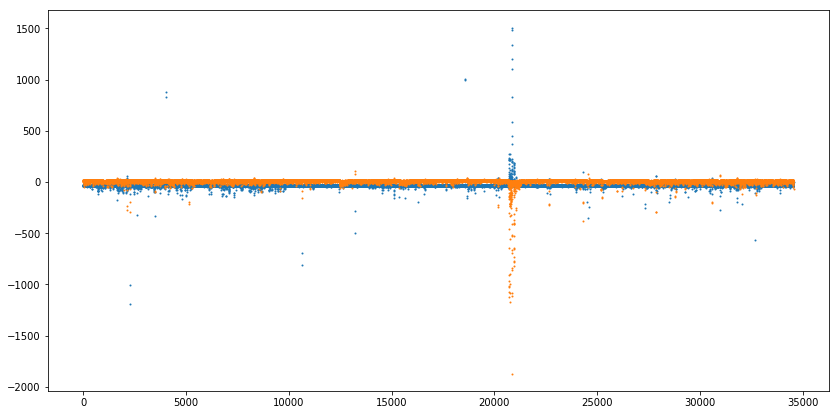

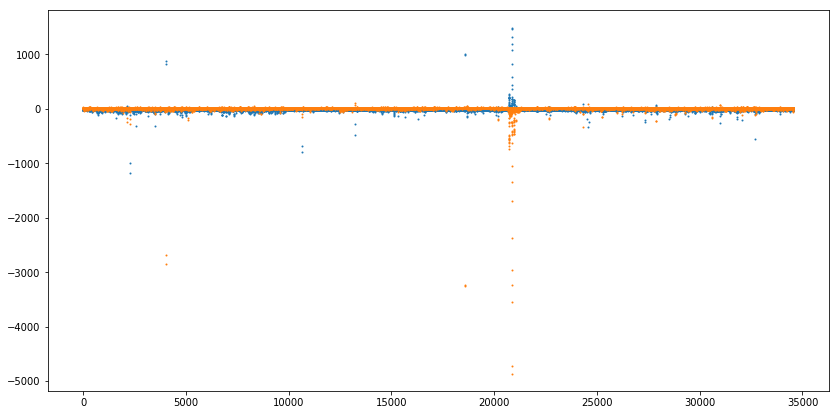

In [132]:
plt.figure(figsize=(14,7))
plt.plot(dLLf,'.',markersize=2)
plt.figure(figsize=(14,7))
plt.plot(dLLv,'.',markersize=2)

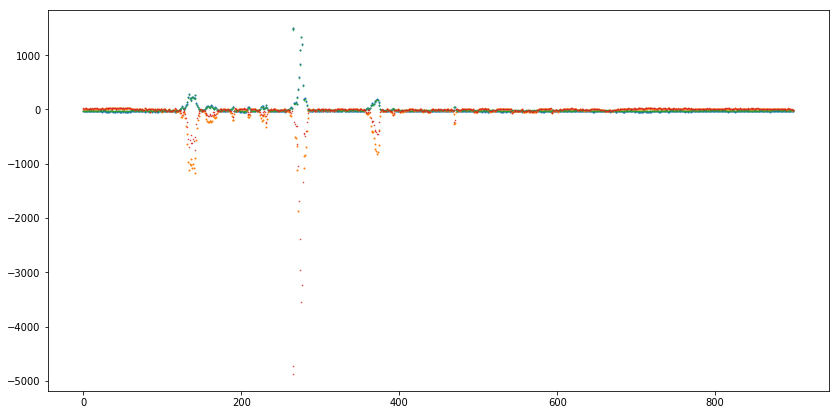

In [133]:
r = range(20600,21500)
plt.figure(figsize=(14,7))
plt.plot(dLLf[r],'.',markersize=2)
plt.plot(dLLv[r],'.',markersize=1)


In [405]:
a = {'b':[[1,2],[6,7]],
     'c':[[2,3],[8,9]]
    }
keys = ['b','c']

In [412]:
d = [(l[0],l[1],i+1) for i,key in enumerate(keys) for l in a[key]]
d

[(1, 2, 1), (6, 7, 1), (2, 3, 2), (8, 9, 2)]

In [413]:
d.sort()
d

[(1, 2, 1), (2, 3, 2), (6, 7, 1), (8, 9, 2)]

In [481]:
dt=.5
def transitions2matrix(t,dt,n):
    A = np.zeros((n+1,n+1))
    A[0,d[0][2]] +=1
    for i in range(len(t)-1):
        if t[i][1] >= t[i+1][0]-dt: # transitions between labled events
            A[t[i][2],t[i+1][2]] +=1
        else:  # transitions between labled events and blanks
            A[t[i][2],0]   +=1
            A[0,t[i+1][2]] += 1
    return A

def tansitions2rates(B,nblankpoints,nclasspoints):
    A = B
    A[0,0] = nblankpoints - np.sum(A[0,:])
    A[0,:] /= np.sum(A[0,:])
    for i in range(len(nclasspoints)):
        if nclasspoints[i]:
            A[i+1,i+1] = nclasspoints[i] - np.sum(A[i+1,:])
            A[i+1,:] /= np.sum(A[i+1,:])
        else: # For classes that do not occur, default to transition to blanks
            A[i+1,:] = 0
            A[i+1,0] = 1
    return A

In [482]:
A = np.zeros((3,3),dtype='float64')
A = transitions2matrix(d,.5,3)

In [483]:
B  = tansitions2rates(A,100,[10,5,0])

In [484]:
B

array([[0.97, 0.02, 0.01, 0.  ],
       [0.1 , 0.8 , 0.1 , 0.  ],
       [0.2 , 0.  , 0.8 , 0.  ],
       [1.  , 0.  , 0.  , 0.  ]])

In [661]:
tv = []
for i in range(10):
    t =np.arange(100)
    tv.append(t)
tvs = np.hstack(tv)

In [662]:
tvs.shape

(1000,)

In [3]:
6//10

0

In [4]:
1.58496687e+09

1584966870.0

In [5]:
1572565228.494363 + 3600

1572568828.494363

In [198]:
any([False, True, False])

True

In [79]:
def intervals_overlap(a,b):
    return (a[0] <= b[0] < a[1]) or (a[0] <= b[1] < a[1]) or (b[0] <= a[0] < b[1]) or (b[0] <= a[1] < b[1])



In [80]:
manual_label_positions = [[0,.5],[3,4],[7,8]]

In [83]:
if not any([intervals_overlap([.1,2],pos) for pos in manual_label_positions]):
    print('do it')
else:
    print('skip it')


skip it
